In [160]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg as la
import seaborn as sns
import scipy.stats as stats

In [161]:
dataset1 = 'data/2D_data_points_1.txt'
dataset2 = 'data/2D_data_points_2.txt'
dataset3 = 'data/3D_data_points.txt'
dataset4 = 'data/6D_data_points.txt'

np.random.seed(1)

In [218]:
dataset_path = dataset4
plot_path = 'plots/dataset4/'

In [215]:
df = pd.read_csv(dataset_path, header=None)

df.head()

,0,1,2,3,4,5
0,-8.9838,-8.8101,-8.7325,6.8276,8.0838,-3.6102
1,-9.0780,-8.9883,-9.1242,7.0751,8.1816,-4.0691
2,7.1802,-5.1141,-8.4475,-0.7136,1.3681,-1.5898
3,10.6290,-9.0872,2.9779,6.4922,10.2654,7.7818
4,-9.0626,-8.9339,-9.0517,6.9821,8.3278,-4.0025


In [204]:
# check the scales of the features
df.describe()

,0,1,2
count,2000.000000,2000.000000,2000.000000
mean,-0.750312,-2.999677,1.996545
std,5.394056,2.647550,4.303115
min,-10.943600,-9.247700,-6.000800
25%,-4.085325,-4.988925,-1.879100
50%,-1.244250,-2.460750,2.994550
75%,2.871450,-1.138950,5.998075
max,8.836400,2.175500,8.086300


In [205]:
def pca(dataframe, dim):
    df = dataframe.copy()
    df_norm = (df - df.mean()) / df.std()   
    cov_mat = np.cov(df_norm.T)
    U, S, Vt = la.svd(cov_mat)
    
    reduced_data = np.dot(df_norm, Vt[:dim,:].T)
    
    return reduced_data

## Source: pca+svd intuition:
https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca#:~:text=Principal%20component%20analysis%20(PCA)%20is,of%20the%20data%20matrix%20X.

## Source: Eigen values are in decreasing order
https://www.youtube.com/watch?v=P5mlg91as1c&ab_channel=ArtificialIntelligence-AllinOne

In [189]:
# # scaling each feature divided bystd. deviation
# df_norm = (df - df.mean()) / df.std()

# #covariance matrix
# cov_mat = np.cov(df_norm.T)
# print('Covariance matrix \n%s' %cov_mat)

# #svd of covariance matrix
# U, S, Vt = la.svd(cov_mat)

# print(Vt)

# # dimention reduction
# k = 2
# reduced_data = np.dot(df.values, Vt[:k, :].T)

# print(reduced_data)


In [216]:
reduced_data = pca(df, 2)

In [217]:
# convert to dataframe
df_reduced = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_reduced.describe()

,PC1,PC2
count,2.203000e+03,2.203000e+03
mean,-2.580273e-17,-2.257739e-17
std,1.647129e+00,1.529757e+00
min,-3.094153e+00,-2.508624e+00
25%,-8.550319e-01,-9.159289e-01
50%,5.626116e-01,-2.925076e-01
75%,9.654355e-01,-5.768114e-02
max,2.116409e+00,3.296918e+00


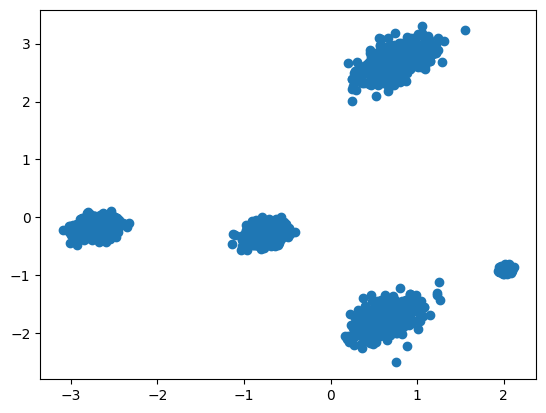

In [219]:
# plot the data along the 2 axis
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.savefig(plot_path + 'pca.png')
plt.show()


In [169]:
def E_step(data, mu, sigma, pi):
    # likelihood of data point given the cluster
    """_summary_

    Args:
        data : reduced to 2 dim datapoints
        mu : mu matrix of shape (k,2)
        sigma : sigma matrix of shape (k,2,2)
        pi : pi matrix of shape (k,)
    Returns:
        likelihood_matrix : matrix of shape (n,k) where n is the number of datapoints
    """
    
    n = data.shape[0]
    k = mu.shape[0]
    likelihood_matrix = np.zeros((n, k))
    
    for i in range(k):
        likelihood_matrix[:, i] = pi[i] * stats.multivariate_normal.pdf(data, mu[i], sigma[i])
        
    # normalize the likelihood matrix
    likelihood_matrix = likelihood_matrix / np.sum(likelihood_matrix, axis=1).reshape(-1, 1)
    
    return likelihood_matrix    

In [170]:
def M_step(likelihood_matrix, data):
    """

    Args:
        likelihood_matrix : pij matrix of shape (n,k)
    Returns:
        mu : mu matrix of shape (k,2)
        sigma : sigma matrix of shape (k,2,2)
        pi : pi matrix of shape (k,)
    """
    
    
    k = likelihood_matrix.shape[1]
    
    # n_i
    n = np.sum(likelihood_matrix, axis=0)
    mu = np.zeros((k, 2))
    sigma = np.zeros((k, 2, 2))
    pi = np.zeros(k)
    
    for i in range(k):
        mu[i] = np.dot(likelihood_matrix[:, i], data) / n[i]
        
        sigma[i] = np.dot(likelihood_matrix[:, i] * (data - mu[i]).T, data - mu[i]) / n[i]
        sigma[i] += 1e-6 * np.eye(2)  # regularization term for avoiding singularity
        
        pi[i] = n[i] / np.sum(n)
    
    return mu, sigma, pi    

In [171]:
def initialization(num_clusters, dim, data):
    k = num_clusters
    n = data.shape[0]
    # mu = np.random.rand(k, dim)
    # sigma = np.array([np.eye(dim)] * k)
    
    indices = np.random.choice(n, k, replace=False)
    mu = data[indices, :]
    
    # Use the overall covariance of the data as the initial covariance for each cluster
    sigma = np.array([np.cov(data.T)] * k)
    
    pi = np.ones(k) / k
    
    return mu, sigma, pi
    
def calculate_log_likelihood(data, k, mu, sigma, pi):
    n = data.shape[0]
    log_likelihood = np.zeros((n, k))
    
    for i in range(k):
        log_likelihood[:, i] = pi[i] * stats.multivariate_normal.pdf(data, mu[i], sigma[i])
    
    # normalize
    #log_likelihood = log_likelihood / np.sum(log_likelihood, axis=1).reshape(-1, 1)  
    log_likelihood = np.sum(np.log(np.sum(log_likelihood, axis=1)))
    
    return log_likelihood
    

In [172]:
def EM_algorithm(data, k, trials=5, epoch=2000, tol=1e-6):
    n = data.shape[0]
    dim = data.shape[1]
    
    best_log_likelihood = -np.inf
    best_mu = None
    best_sigma = None
    best_pi = None
    best_iteration = None
    
    
    likelihood_matrix = np.zeros((n, k))
    log_likelihood_list = []
    
    
    for t in range(trials):
        
        prev_log_likelihood = None
        # Random initialization of parameters
        mu, sigma, pi = initialization(k, dim, data)
        
        for iteration in range(epoch):
            # E-step
            likelihood_matrix = E_step(data, mu, sigma, pi)
            
            # M-step
            new_mu, new_sigma, new_pi = M_step(likelihood_matrix, data)
            
            # log likelihood
            log_likelihood = calculate_log_likelihood(data, k, new_mu, new_sigma, new_pi)
            
            # check for convergence
            if np.abs(np.sum(new_mu - mu)) < tol and np.abs(np.sum(new_sigma - sigma)) < tol and np.abs(np.sum(new_pi - pi)) < tol:
                break
            
            prev_log_likelihood = log_likelihood
            
            mu = new_mu
            sigma = new_sigma
            pi = new_pi
        
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_mu = mu
            best_sigma = sigma
            best_pi = pi
            best_iteration = iteration
        
    return best_mu, best_sigma, best_pi, best_iteration, best_log_likelihood

In [220]:
# check em algo 
k = 5
trials = 5
epoch = 500
mu, sigma, pi, iterations, best_log_likihood = EM_algorithm(reduced_data, k=k, trials=trials, epoch=epoch)

# check the log likelihood
print(best_log_likihood)
print(iterations)

232.28127018959603
59


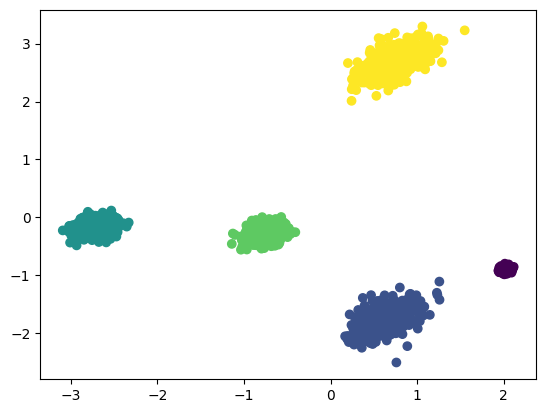

In [221]:
# plot the clusters, each cluster is represented by a different color for k = 5
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=np.argmax(E_step(reduced_data, mu, sigma, pi), axis=1))
#plt.savefig('plots/em.png')
plt.show()

In [177]:
from matplotlib.patches import Ellipse

def draw_gmm(data, mu, sigma, pi, iteration):
    plt.scatter(data[:, 0], data[:, 1], c=np.argmax(E_step(data, mu, sigma, pi), axis=1))
    
    for i in range(len(pi)):
        draw_ellipse(mu[i], sigma[i], plt.gca(), color='red', weights=pi[i], alpha=0.3)
        
    plt.title('GMM with {} clusters after {} iterations'.format(len(pi), iteration))
    plt.legend()
    plt.show()
        

# Function to draw ellipse
def draw_ellipse(mu, sigma, ax, color, weights=None, **kwargs):
    if weights is None:
        weights = [1] * len(mu)
    for i in range(len(mu)):
        # set color for each cluster
        kwargs['color'] = color[i]
        U, s, Vt = la.svd(sigma[i])
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        for nsig in range(1, 4):
            ax.add_patch(Ellipse(mu[i], nsig * width, nsig * height, angle, **kwargs))
            
def update(frame):
    plt.clf()
    draw_gmm(reduced_data, mu[frame], sigma[frame], pi[frame], frame)

k = 3, log likelihood = -2812.9911436555503, iterations = 15


C:\Users\Osama Haque\AppData\Local\Temp\ipykernel_8860\4121873800.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(mu))
C:\Users\Osama Haque\AppData\Local\Temp\ipykernel_8860\4266393434.py:25: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(mu[i], nsig * width, nsig * height, angle, **kwargs))


k = 4, log likelihood = -989.6602317710092, iterations = 14
k = 5, log likelihood = 232.28127018959603, iterations = 60
k = 6, log likelihood = 239.48134887537145, iterations = 314
k = 7, log likelihood = 241.415129788608, iterations = 499
k = 8, log likelihood = 259.60915064185, iterations = 499
Best k = 8
Best log likelihood = 259.60915064185


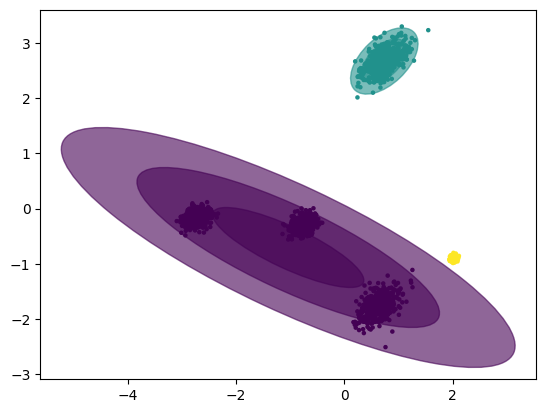

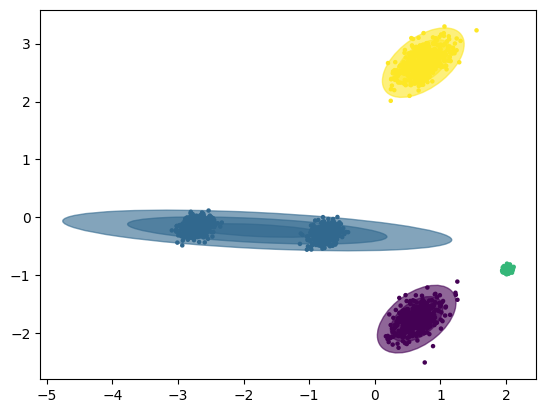

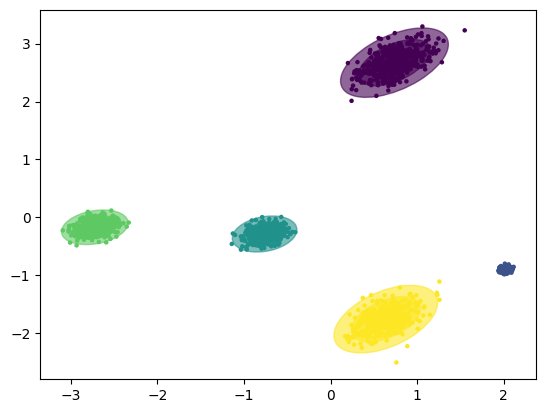

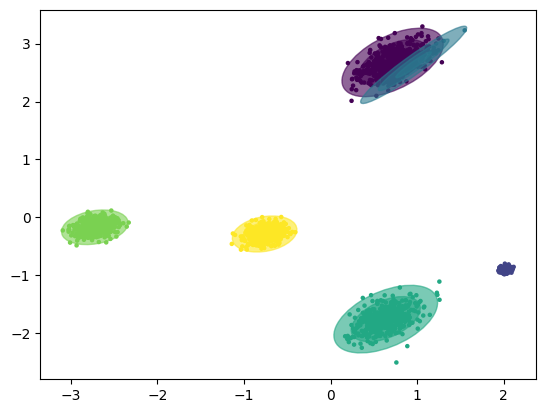

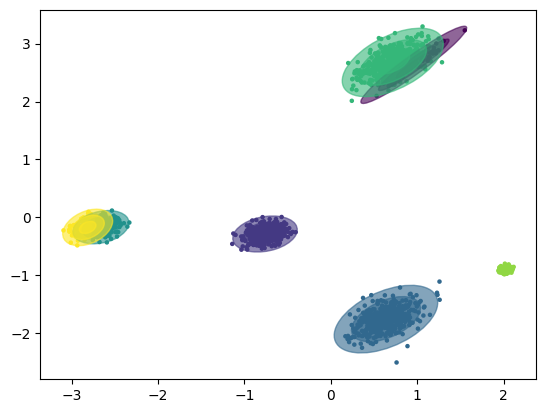

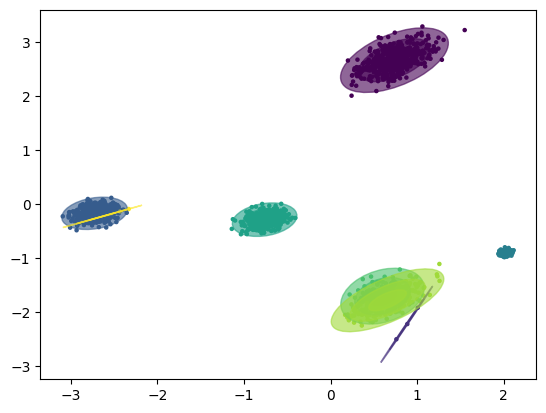

In [222]:
trials = 5
epoch = 500
k_values = [3, 4, 5, 6, 7, 8]
best_log_values = []
best_k_value = None
best_parameters = None  
best_log_likelihood = -np.inf   


for k in k_values:
    mu, sigma, pi, iterations, log_likeihood = EM_algorithm(reduced_data, k=k, trials=trials, epoch=epoch)
    best_log_values.append(log_likeihood)
    print('k = {}, log likelihood = {}, iterations = {}'.format(k, log_likeihood, iterations))
    if log_likeihood > best_log_likelihood:
        best_log_likelihood = log_likeihood
        best_parameters = (mu, sigma, pi)
        best_k_value = k
        
    fig, ax = plt.subplots()
    cluster_assignments = np.argmax(E_step(reduced_data, mu, sigma, pi), axis=1)
    cmap = plt.cm.get_cmap('viridis', len(mu))

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_assignments, cmap=cmap, s=5)

    draw_ellipse(mu, sigma, ax, color=[cmap(i) for i in range(len(mu))], weights=pi, alpha=0.6)
    
    plt.savefig(plot_path + 'em_{}.png'.format(k))
    #plt.show()   
    

print('Best k = {}'.format(best_k_value))
print('Best log likelihood = {}'.format(best_log_likelihood))    

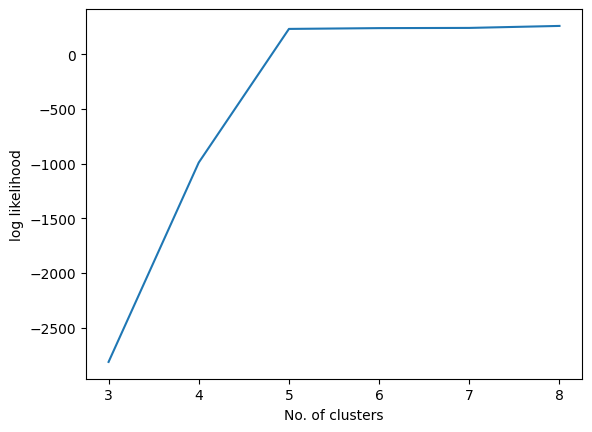

In [223]:
#clear plot    
plt.plot(k_values, best_log_values)
plt.xlabel('No. of clusters')
plt.ylabel('log likelihood')
plt.savefig(plot_path + 'log_likelihood_vs_k.png')

C:\Users\Osama Haque\AppData\Local\Temp\ipykernel_8860\1750957762.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(mu))
C:\Users\Osama Haque\AppData\Local\Temp\ipykernel_8860\1055827651.py:27: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(mu[i], nsig * width, nsig * height, angle, **kwargs))


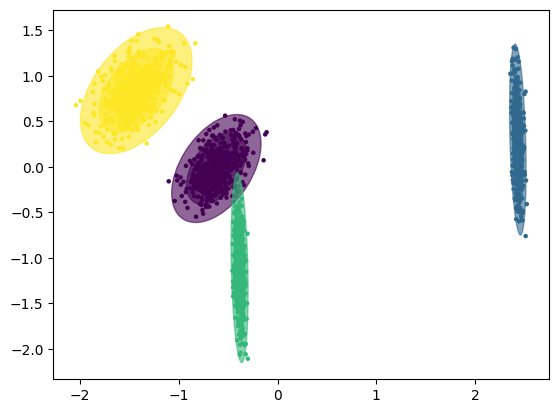

In [37]:
#(mus, sigmas, pis) = best_parameters
fig, ax = plt.subplots()
cluster_assignments = np.argmax(E_step(reduced_data, mu, sigma, pi), axis=1)

# Create a colormap for the clusters
cmap = plt.cm.get_cmap('viridis', len(mu))

# Plot scatter points with cluster colors
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_assignments, cmap=cmap, s=5)

# Create a new figure for ellipses


# Draw ellipses with matching colors
draw_ellipse(mu, sigma, ax, color=[cmap(i) for i in range(len(mu))], weights=pi, alpha=0.6)

# Show the plots
plt.show()

## Making Animation

In [224]:
import imageio
import io

def EM_algorithm_create_gif(data, k, trials=5, epoch=2000, tol=1e-6):
    n = data.shape[0]
    dim = data.shape[1]

    best_log_likelihood = -np.inf
    best_mu = None
    best_sigma = None
    best_pi = None
    best_iteration = None

    likelihood_matrix = np.zeros((n, k))
    log_likelihood_list = []

    # Create a colormap for the clusters
    cmap = plt.cm.get_cmap('viridis', k)

    fig, ax = plt.subplots()
    
    gif_images = []
    
    for trials in range(1, trials + 1):

        mu, sigma, pi = initialization(k, dim, data)

        

        for iter in range(1, epoch + 1):
            # E-step
            likelihood_matrix = E_step(data, mu, sigma, pi)

            # M-step
            new_mu, new_sigma, new_pi = M_step(likelihood_matrix, data)

            # log likelihood
            log_likelihood = calculate_log_likelihood(data, k, new_mu, new_sigma, new_pi)

            # check for convergence
            if np.abs(np.sum(new_mu - mu)) < tol and np.abs(np.sum(new_sigma - sigma)) < tol and np.abs(
                    np.sum(new_pi - pi)) < tol:
                break

            mu = new_mu
            sigma = new_sigma
            pi = new_pi

            if iter % 1 == 0:
                # Clear previous plot and draw new one
                ax.clear()

                # Plot scatter points with cluster colors
                cluster_assignments = np.argmax(likelihood_matrix, axis=1)
                plt.scatter(data[:, 0], data[:, 1], c=cluster_assignments, cmap=cmap, s=1)

                # Draw ellipses with matching colors
                draw_ellipse(mu, sigma, ax, color=[cmap(i) for i in range(len(mu))], weights=pi, alpha=0.6)
                
                # Set x and y limits explicitly
                plt.xlim(min(data[:, 0]), max(data[:, 0]))
                plt.ylim(min(data[:, 1]), max(data[:, 1]))
                
                # Add title to the plot
                plt.title(f'GMM-EM {k} Gaussian, Iteration: {iter}, Trial: {trials}')
                # Set x and y limits explicitly
                plt.xlim(min(data[:, 0]), max(data[:, 0]))
                plt.ylim(min(data[:, 1]), max(data[:, 1]))
                
                plt.xlabel('x')
                plt.ylabel('y')
                #plt.legend()

                # Convert plot to image
                buf = io.BytesIO()
                plt.savefig(buf, format='png')
                buf.seek(0)
                gif_images.append(imageio.imread(buf))
                
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_mu = mu
            best_sigma = sigma
            best_pi = pi
            best_iteration = iter

    # Save GIF
    imageio.mimsave(plot_path + 'em_animation.gif', gif_images, fps=4)

    return best_mu, best_sigma, best_pi, best_iteration, best_log_likelihood


C:\Users\Osama Haque\AppData\Local\Temp\ipykernel_8860\3216538935.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', k)
C:\Users\Osama Haque\AppData\Local\Temp\ipykernel_8860\4266393434.py:25: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(mu[i], nsig * width, nsig * height, angle, **kwargs))
C:\Users\Osama Haque\AppData\Local\Temp\ipykernel_8860\3216538935.py:78: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_images.

iteration = 100


C:\Users\Osama Haque\AppData\Local\Temp\ipykernel_8860\1157424288.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(best_mu))


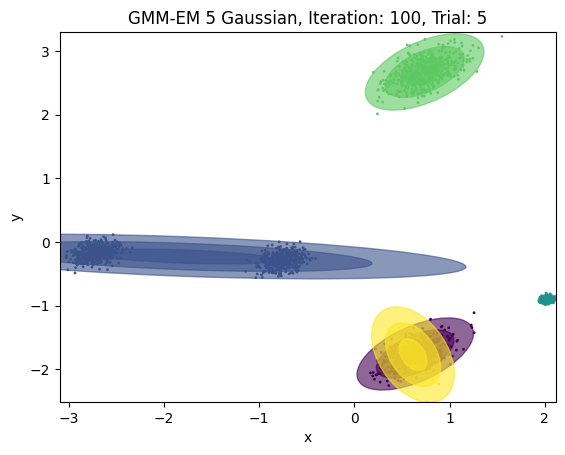

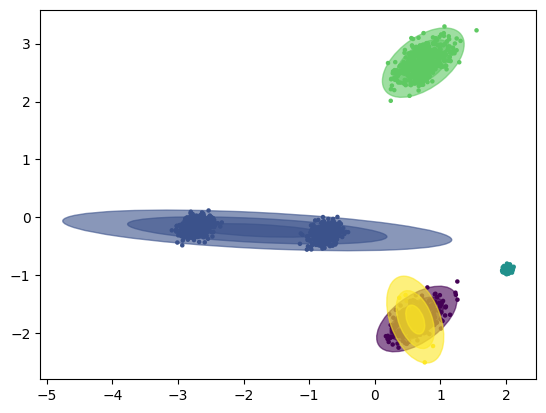

In [225]:
best_mu, best_sigma, best_pi, iteration, _ = EM_algorithm_create_gif(reduced_data, k=5, trials=5, epoch=100)
print("iteration = {}".format(iteration))

# plot for the best parameters
fig, ax = plt.subplots()
cluster_assignments = np.argmax(E_step(reduced_data, best_mu, best_sigma, best_pi), axis=1)

# Create a colormap for the clusters
cmap = plt.cm.get_cmap('viridis', len(best_mu))

# Plot scatter points with cluster colors
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_assignments, cmap=cmap, s=5)

# Create a new figure for ellipses
draw_ellipse(best_mu, best_sigma, ax, color=[cmap(i) for i in range(len(best_mu))], weights=best_pi, alpha=0.6)

plt.show()


